# Tutorial: Deep Learning 101 for Audio-based MIR - Self-supervised learning

*Geoffroy Peeters, Gabriel Meseguer-Brocal, Alain Riou, Stefan Lattner*

Self-supervised learning (SSL) is a paradigm in machine learning that aims to learn meaningful representations from data without relying on labels. The goal is to leverage the natural structure in data to define tasks that can guide the model’s learning process. This approach has grown in popularity for applications in computer vision, natural language processing, and audio processing, where labeled data is often scarce or costly to obtain.

In this tutorial, we’ll focus on **Siamese architectures**, which are particularly well-suited to SSL. Siamese networks learn by comparing **positive pairs** of inputs, effectively constructing a task from data itself to learn useful representations.

### Key Concepts in Siamese Architectures for SSL

A Siamese network takes two input samples $x_1$ and $x_2$ and projects them into a shared latent space using a neural network $f_{\theta}$ with parameters $\theta$. The underlying idea is simple yet powerful:
  
1. **Positive pairs**: Each input pair $ (x_1, x_2) $ is chosen such that $x_1$ and $x_2$ are related in some way (e.g., two different views of the same object or nearby audio chunks in a music track). Since these inputs are “similar,” we want their representations in the latent space to be close.

2. **Learning Objective**: To achieve this, we optimize the parameters $\theta$ of $f_{\theta}$ by minimizing the distance between $f_{\theta}(x_1)$ and $f_{\theta}(x_2)$ in the latent space.

Training the model in this way encourages it to focus on commonalities between similar samples, capturing meaningful and invariant features in the data. The resulting learned representations are useful for downstream tasks, even when labeled data is unavailable.

![Siamese network](https://github.com/geoffroypeeters/deeplearning-101-audiomir_notebook/raw/ssl/images/ssl/a4ece110-e64b-4362-ad4d-28cdcf396963.png)


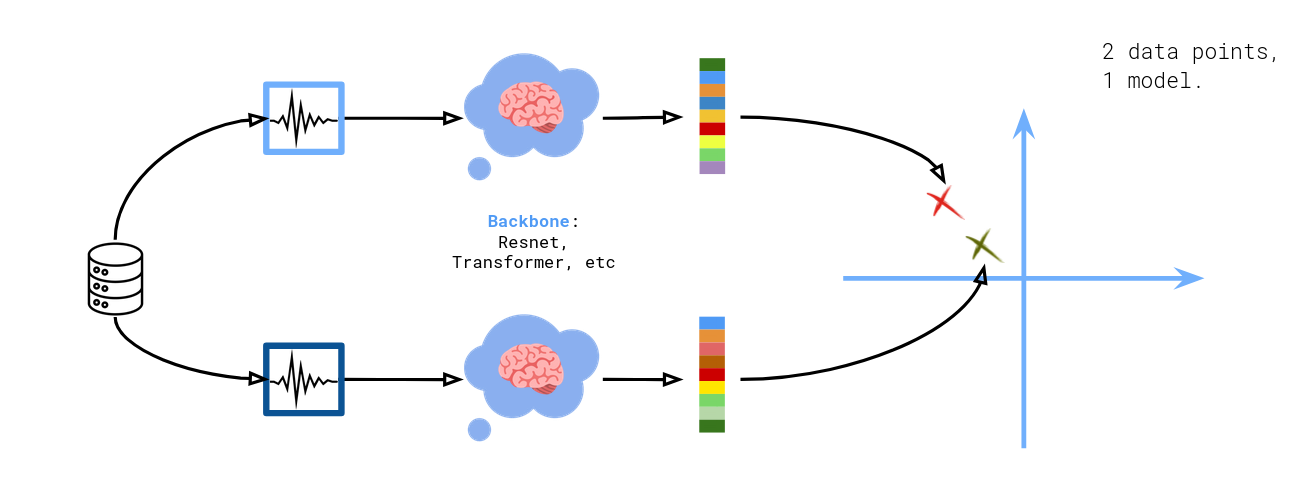

## 0. Installation, imports, downloads, etc.

Before effectively implementing anything, we first have to install and import all the dependencies, and downloading the dataset.

**Disclaimer:** This notebook is supposed to run in a Colab environment, and we only install minimal dependencies.
As in the previous notebooks, we will rely on Lightning to train our neural networks.

Here is the [Colab link](https://colab.research.google.com/drive/1lVpAKC1Tc8BRDKYnyna6IplxzpW7rdby?usp=sharing).

In [1]:
# install requirements
!pip install lightning
!pip install torchaudio-augmentations
!pip install umap-learn

Let us import all the Python libraries we will need:

In [2]:
# imports
import glob
import os
from copy import deepcopy
from typing import Any, Tuple

import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchaudio

import lightning.pytorch as pl

%matplotlib inline

#### Downloading datasets

Before training any deep learning model, we need data to train on. In this notebook, we will use the [MagnaTagATune dataset](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset). To keep it simple, we will pretrain our model on a (non-annotated) subset of the data, then keep the rest for evaluation.

The following script will download all the data we need for this notebook.

In [3]:
import time

t0 = time.time()

!wget -nc https://raw.githubusercontent.com/SonyCSLParis/test-lfs/refs/heads/master/download.sh
!chmod u+x download.sh
!./download.sh mtt_ssl
t1 = time.time()

print("Done. Time elapsed: {:.0f} minutes and {:.0f} seconds.".format(*divmod(t1-t0, 60)))

File ‘download.sh’ already there; not retrieving.

Dataset mtt_ssl already downloaded. Skip.
Done. Time elapsed: 0 minutes and 0 seconds.


In [4]:
def count_audios(folder):
    return len(glob.glob(f"{folder}/**/*.mp3"))

for subfolder in os.listdir("mtt_ssl"):
    count = count_audios(os.path.join("mtt_ssl", subfolder))
    print(f"{subfolder}:\t{count:d} files")

pretrain:	23266 files
.done:	0 files
train:	2069 files
test:	525 files


## 1. Training a SSL model

In this part, we will implement the different components of a Siamese architecture, namely its structure, the underlying backbone architecture and the criterion to optimize. In addition, we implement the mechanism to create the positive pairs.

### 1.1. Building a dataset of positive pairs

The first step is to define what are the positive pairs that our model to process, and how to build them. In practice, this mechanism will be directly implemented in a standard PyTorch `Dataset`.

When dealing with music, common strategies to create pairs of similar points without supervision are:
- extracting different chunks from the same song
- applying audio effects to the audio chunk

Recall that the network will learn to find what the elements of the pair have **in common**. For example, if you use chunks of the same song, it will probably capture info such as tonality, genre, tempo, but not chords or timbre. On the contrary, if you transpose your audio to create pairs, it will learn to discard pitch information.

In other words, you control what your model captures by choosing how you compute pairs. And of course, you can combine different techniques!

Let's start by implementing a simple dataset that extracts chunks of audio and randomly apply several transforms.
The convenient thing when training a SSL model is that we do not need any label, so we can recursively explore folders and use any audio data we find, which makes the `__init__` function super simple.

For the transforms, we directly use the transforms implemented in the [torchaudio-augmentations](https://github.com/Spijkervet/torchaudio-augmentations) repository from Janne Spijkervet (who did a tutorial about SSL in ISMIR 2021, btw). Our `__getitem__` function then just picks an audio, extracts two chunks from it and randomly applies transforms before returning the pair.

In [5]:
from torchaudio_augmentations import *


class PairDataset(torch.utils.data.Dataset):
    """
    A custom dataset class that retrieves pairs of random audio chunks 
    from WAV files in a specified directory.

    Args:
        data_dir (str): Path to the directory containing WAV files.
        chunk_duration (float): Duration of the audio chunks in seconds. Defaults to 10 seconds.

    Attributes:
        paths (List[str]): List of paths to all WAV files in the dataset.
        chunk_duration (float): Duration of the audio chunks to be extracted.
        transforms (torch.nn.Module): Placeholder for audio augmentation/transforms.
    """
    def __init__(self, data_dir: str, chunk_duration: float = 10.):
        self.paths = glob.glob(f"{data_dir}/**/*.mp3", recursive=True)
        self.chunk_duration = chunk_duration

        # Define the set of transforms here
        self.transforms = nn.Sequential(*[
            RandomApply([PolarityInversion()], p=0.8),
            RandomApply([Noise(min_snr=0.001, max_snr=0.005)], p=0.3),
            RandomApply([Gain()], p=0.2),
            HighLowPass(sample_rate=22050), # this augmentation will always be applied in this aumgentation chain!
            RandomApply([Delay(sample_rate=22050)], p=0.5),
            RandomApply([Reverb(sample_rate=22050)], p=0.3)
        ])

    def __len__(self) -> int:
        """
        Returns the number of audio files in the dataset.

        Returns:
            int: The total number of WAV files in the dataset.
        """
        return len(self.paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves a pair of random audio chunks from a WAV file.

        Args:
            idx (int): Index of the file to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Two randomly extracted mono audio chunks 
            as tensors from the selected WAV file.
        """
        # Retrieve file path and audio info
        path = self.paths[idx]
        info = torchaudio.info(path)
        sr = info.sample_rate
        total_frames = info.num_frames

        # Calculate the number of frames per chunk
        num_frames = int(self.chunk_duration * sr)

        # Randomly select starting points for two chunks
        i1, i2 = torch.randint(0, total_frames - num_frames, (2,))

        # Load two audio chunks from the file
        x1, _ = torchaudio.load(path, frame_offset=i1, num_frames=num_frames)
        x2, _ = torchaudio.load(path, frame_offset=i2, num_frames=num_frames)

        # Apply transforms (if any) to both chunks
        x1 = self.transforms(x1)
        x2 = self.transforms(x2)
        
        # Convert stereo to mono by summing across the channel dimension
        x1 = x1.sum(dim=0)
        x2 = x2.sum(dim=0)

        return x1, x2

Let's have a look of what we get with some examples from our dataset:

In [6]:
data_dir = "mtt_ssl/pretrain"
dataset = PairDataset(data_dir, chunk_duration=2.7)
print(f"Loaded dataset {data_dir}. Total: {len(dataset)} files.")

for i in range(3):
    print(f"Pair {i+1:d}")
    j = torch.randint(0, len(dataset), ()).item()
    x1, x2 = dataset[j]
    ipd.display(ipd.Audio(x1, rate=22050))
    ipd.display(ipd.Audio(x2, rate=22050))

Loaded dataset mtt_ssl/pretrain. Total: 23266 files.
Pair 1


Pair 2


Pair 3


### 1.2. Implementing Siamese Networks as a `LightningModule`

Siamese Networks are a simple structure just composed of two... siamese networks, and each of them projects an element of the pair in the latent space. Then a criterion between the two projections is being optimized.

*But why only two? Couldn't we use more than only two views?* Actually yes, some recent works such as [this article from ICLR 2024 by Shidani et al.](https://arxiv.org/pdf/2403.05490) suggest that Siamese networks can be generalized to more than pairs of two views. However, as 99% of the papers, we will stick to pairs in this tutorial.

Let us build our Siamese networks as a `LightningModule`. Recall that it is just a training paradigm that does not depend on the underlying architectures, so we can make it quite modular. Our LightningModule just takes two main arguments:
- The architecture of the network itself
- The loss criterion that we want to optimize

That's it!

An interesting trick to improve the generalization abilities of the learned embeddings is not to use the outputs of the last layer of the network but a previous one after training. Doing so enables the mitigation of the misalignment between the training objective and the actual downstream applications. Some French researchers named this trick Guillotine Regularization and studied it in depth in [this journal paper from Bordes et al.](https://arxiv.org/pdf/2206.13378).

In practice, we implement this trick by splitting our network in two successive parts, usually referred to as the **encoder** and the **projector**. In our case, as often, we will use a domain-specific architecture for the encoder and a simple MLP with 2 layers for the projector.

In [7]:
class SiameseNetwork(pl.LightningModule):
    """
    A Siamese Network implemented using PyTorch Lightning, designed to work with
    a backbone neural network and a loss function. The network projects two input
    samples into a latent space and optimizes their relationship via the provided loss function.

    Args:
        encoder (torch.nn.Module): The feature extractor model that projects inputs into a latent space.
        loss_fn (torch.nn.Module): The loss function used to optimize the network based on the similarity 
                                   or dissimilarity between the two inputs.
    """
    def __init__(self,
                 encoder: torch.nn.Module,
                 loss_fn: torch.nn.Module,
                 in_channels: int = 512,
                 out_channels: int = 64):
        super(SiameseNetwork, self).__init__()

        self.encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(in_channels, in_channels),
            nn.ReLU(),
            nn.Linear(in_channels, out_channels)
        )
        
        self.loss_fn = loss_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the backbone network.

        Args:
            x (torch.Tensor): Input tensor to be projected into the latent space.

        Returns:
            torch.Tensor: Latent representation of the input.
        """
        y = self.encoder(x)
        return self.projector(y)

    def training_step(self, batch: Any, batch_idx: int) -> torch.Tensor:
        """
        Defines a single training step, including the forward pass and loss computation.

        Args:
            batch (Any): A batch of data, expected to contain two input tensors.
            batch_idx (int): Index of the current batch.

        Returns:
            torch.Tensor: The computed loss for this step.
        """
        x1, x2 = batch

        # Project x1 and x2 into the latent space
        z1 = self.forward(x1)
        z2 = self.forward(x2)

        # Compute the loss based on z1 and z2
        loss = self.loss_fn(z1, z2)

        # Log the loss for visualization and monitoring
        self.log("loss", loss, prog_bar=True)

        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configures the optimizer for training.

        Returns:
            torch.optim.Optimizer: Adam optimizer with a learning rate of 1e-4.
        """
        return torch.optim.Adam(self.parameters(), lr=1e-4)

### 1.3. Architecture of the model

Now let us define those two components.
In this notebook, we use [SampleCNN](https://github.com/kyungyunlee/sampleCNN-pytorch) for the architecture of the backbone.
In fact, even if modern SSL architectures use more sophisticated architectures, this network directly processes waveforms and has shown good performances in the [CLMR](https://arxiv.org/pdf/2103.09410) paper by Janne Spijkervet (again!). Also, It is small enough to be trained without huge GPU resources.

Again, the choice of the architecture is independent from the paradigm. Here we use SampleCNN as an example, but feel free to try other architectures, frontends...

In [8]:
class SampleCNN(nn.Module):
    def __init__(self):
        super(SampleCNN, self).__init__()

        # 59049 x 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU())
        # 19683 x 128
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3))
        # 6561 x 128
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 2187 x 128
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 729 x 256
        self.conv5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 243 x 256
        self.conv6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3),
            nn.Dropout(p=0.5))
        # 81 x 256
        self.conv7 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 27 x 256
        self.conv8 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 9 x 256
        self.conv9 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 3 x 256
        self.conv10 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 1 x 512
        self.conv11 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5))

    def forward(self, x):
        # input x : 23 x 59049 x 1
        # expected conv1d input : minibatch_size x num_channel x width

        x = x.view(x.shape[0], 1, -1)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.conv9(out)
        out = self.conv10(out)
        out = self.conv11(out)

        # average along time axis to get a single embedding per audio
        return out.mean(dim=-1)

### Bonus: Plot PCA along training with a Lightning `Callback`

In SSL, the **pretext task** is not necessarily aligned with the **downstream task**, so just looking at the loss is not enough for monitoring the training.

In this notebook, we therefore implement a Lightning callback to plot the PCA of our dataset at the end of each epoch. This will enable us to *see* the latent space that our model is learning.

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
import lightning.pytorch as pl
import os

class PCAEmbeddingPlotCallback(pl.Callback):
    def __init__(self, n_batches: int = 5, n_epochs: int = 1):
        self.n_batches = n_batches
        self.n_epochs = n_epochs
        self.current_loss = None

    def on_train_batch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule, outputs: torch.Tensor, batch: Any, batch_idx: int) -> None:
        if trainer.is_last_batch:
            self.current_loss = outputs["loss"].cpu().item()

    def on_train_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        if (trainer.current_epoch + 1) % self.n_epochs == 0:
            self.save_pca_plot(pl_module, trainer, epoch=trainer.current_epoch + 1)

    def on_train_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        # Show final PCA plot
        self.plot_pca_embeddings(pl_module, trainer)

    def save_pca_plot(self, pl_module: pl.LightningModule, trainer: pl.Trainer, epoch) -> None:
        """
        Saves the PCA plot to disk at the checkpoint directory for specified epochs.
        """
        fig, ax = self.plot_pca_embeddings(pl_module, trainer)
        
        checkpoint_dir = trainer.logger.log_dir if trainer.logger else "."
        filename = os.path.join(checkpoint_dir, f"pca_{epoch}.png")
        fig.savefig(filename)
        plt.close(fig)  # Close the figure to free memory

    def plot_pca_embeddings(self, pl_module: pl.LightningModule, trainer: pl.Trainer):
        """
        Plots and returns the PCA of embeddings of the model's backbone.
        """
        pl_module.eval()
        all_embeddings = []

        with torch.no_grad():
            for i, batch in enumerate(trainer.train_dataloader):
                if i >= self.n_batches:
                    break
                inputs = batch[0].to(pl_module.device)
                embeddings = pl_module(inputs)
                all_embeddings.append(embeddings.cpu().numpy())

        all_embeddings = np.concatenate(all_embeddings, axis=0)
        all_embeddings /= np.linalg.norm(all_embeddings, axis=-1, keepdims=True)

        # Perform PCA to reduce embeddings to 2D
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(all_embeddings)

        # Create the plot
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.scatter(pca_result[:, 0], pca_result[:, 1], c='b', alpha=0.3)
        ax.set_title(f'PCA of Embeddings (Final Epoch, loss: {self.current_loss:.3f})')
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        plt.grid()

        # Return figure to either save or display
        return fig, ax


### 1.4. Train!

We now have all the necessary elements to train our model (dataset, Siamese network, architecture...)

Recall that Siamese networks consist in pushing together the representations of inputs that are similar. We therefore want our network to minimize the Mean Squared Error within a pair. Let's train this model and see what is happening...

Trainer will use only 1 of 7 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=7)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alain/miniconda3/envs/ar/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard

Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=3` reached.


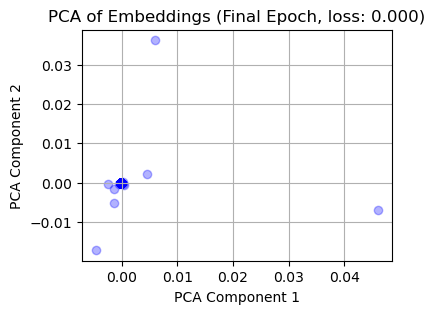

In [10]:
# build dataloader
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=96,              # use approximately 8 GB of memory
                                         num_workers=os.cpu_count(), # use one worker for computing batches of pairs per CPU you have
                                         shuffle=True,               # elements of the dataset should be sent in a random order
                                         pin_memory=True,            # I never understood this but set it to True
                                         persistent_workers=True)    # reuse the existing workers instead of creating new ones between each epoch

# build model
sample_cnn = SampleCNN()
model = SiameseNetwork(sample_cnn, loss_fn=nn.MSELoss())

# callbacks
model_checkpoint = pl.callbacks.ModelCheckpoint(dirpath="logs/mse", save_on_train_epoch_end=True, enable_version_counter=False)
pca = PCAEmbeddingPlotCallback()

trainer = pl.Trainer(accelerator='gpu', precision='16-mixed', max_epochs=3, callbacks=[model_checkpoint, pca])

try:  # sometimes the GPU memory is not properly freed after a training in notebooks, this try-finally clause seems to help a bit
    trainer.fit(model, dataloader)
finally:
    torch.cuda.empty_cache()

Not exactly what we would like... Actually, neural networks are quite lazy, so if you only ask to push together **similar** inputs without any additional constraints, it will simply push together **all** inputs.

This phenomenon is called **collapse**, and a lot of research has been about how to prevent this phenomenon to happen. In particular, the most widely technique is to use a contrastive learning. In other words, we want to have **positive pairs** that we push together, but also **negative pairs** that we push far away from each other.

![Negative pairs](https://github.com/geoffroypeeters/deeplearning-101-audiomir_notebook/raw/ssl/images/ssl/5e51a5cc-b970-44f9-9ba6-7ccfc2833399.png)

*We know how to choose the positive pairs, but how to choose the negative ones?* Well, a simple yet effective is to say that everything that is not a positive pair is a negative pair. Practically speaking, since we anyway process batches of inputs, we use the other elements of a batch to create these negative pairs.
Given a pair of two batches of size $N$, we concatenate both into a big matrix $Z = (z_1, \dots, z_{2N}) \in \mathbb{R}^{2N \times d}$. For $1 \leq i \leq 2N$, let $i^+$ be the index of the corresponding positive pair (i.e. $i^+ = i \pm N$). Overall, the formula looks like this:

![Contrastive loss](https://github.com/geoffroypeeters/deeplearning-101-audiomir_notebook/raw/ssl/images/ssl/5f59560e-eda0-43b3-8def-6f24c39f3ff1.png)

where $\text{sim}(z_i, z_j)$ denotes the cosine similarity between vectors $z_i$ and $z_j$ and $\tau$ is a fixed temperature hyperparameter.
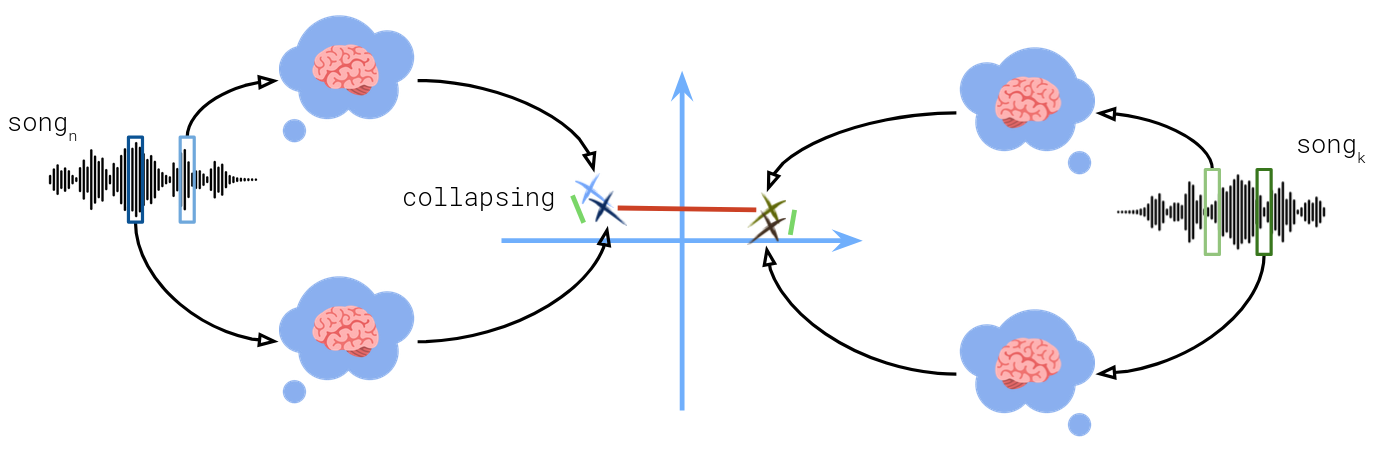
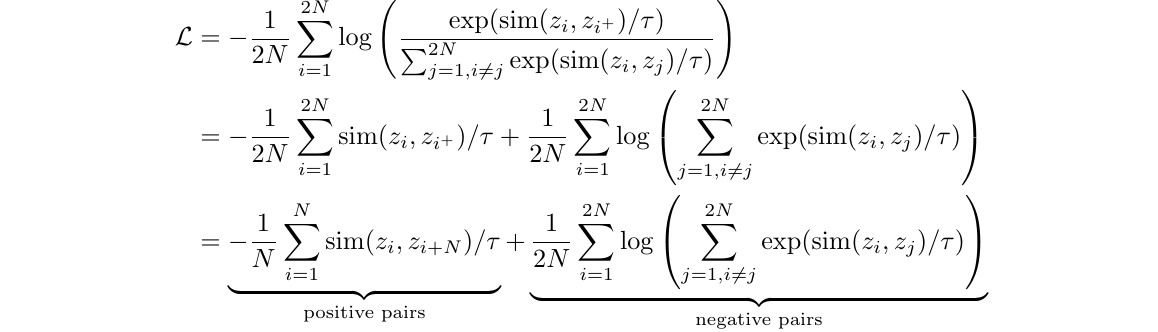

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    A contrastive loss function designed for self-supervised learning. It computes
    the similarity between two sets of embeddings (z1, z2) and aims to maximize the similarity 
    between positive pairs (same inputs) and minimize it between negative pairs (different inputs).

    Args:
        temperature (float): A scaling factor applied to the similarity scores. Defaults to 0.1.
    """
    def __init__(self, temperature: float = 0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
        """
        Computes the contrastive loss between two sets of embeddings.

        Args:
            z1 (torch.Tensor): A batch of embeddings from the first view (e.g., first audio chunk).
            z2 (torch.Tensor): A batch of embeddings from the second view (e.g., second audio chunk).

        Returns:
            torch.Tensor: The contrastive loss computed from the similarity between positive and negative pairs.
        """
        n = z1.size(0)
        
        # Concatenate z1 and z2 along the batch dimension and normalize them
        z = torch.nn.functional.normalize(torch.cat((z1, z2)))

        # Compute cosine similarity matrix scaled by temperature
        sim = torch.mm(z, z.t()).div_(self.temperature)

        # Positive loss: average of n-diagonal elements (corresponding to positive pairs)
        pos_loss = -torch.diag(sim, diagonal=n).mean()

        # Negative loss: log of the sum of the exponentiated similarities for negative pairs
        exp_sim = sim.exp_().clone()  # Avoid in-place ops that interfere with autograd
        exp_sim.fill_diagonal_(0)     # Set diagonal elements (positive pairs) to 0

        neg_loss = exp_sim.sum(dim=1).log_().mean()

        # Return the combined loss (positive + negative)
        return pos_loss + neg_loss


And now train our model with our new contrastive loss:

In [12]:
# build dataloader
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=96,
                                         num_workers=os.cpu_count(),
                                         shuffle=True,
                                         pin_memory=True,
                                         persistent_workers=True)

# Build the model
sample_cnn = SampleCNN()
model = SiameseNetwork(sample_cnn, loss_fn=ContrastiveLoss(temperature=0.5))

# Define callbacks: the first one enables to store checkpoints along training, and the second one plots the PCA of the learned latent space
model_checkpoint = pl.callbacks.ModelCheckpoint(dirpath="logs/x-ent",
                                                save_last=True,
                                                save_on_train_epoch_end=True,
                                                enable_version_counter=False)
pca = PCAEmbeddingPlotCallback()

# Define the trainer. To speed-up training and reduce memory footprint, we use 16-bit mixed precision
trainer = pl.Trainer(accelerator='gpu', precision='16-mixed', max_epochs=500, callbacks=[model_checkpoint, pca])

# Sometimes the training crashes :(
# In that case, it is better to reload the latest checkpoint instead of restarting from scratch
ckpt_path = os.path.join(model_checkpoint.dirpath, "last.ckpt")
if not os.path.exists(ckpt_path):
    ckpt_path = None

try:
    trainer.fit(model, dataloader, ckpt_path=ckpt_path)
finally:
    torch.cuda.empty_cache()

Trainer will use only 1 of 7 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=7)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alain/miniconda3/envs/ar/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory logs/x-ent exists and is not empty.
Restoring states from the checkpoint path at logs/x-ent/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name      | Type            | Params
----------------------------------------------
0 | encoder   | SampleCNN       | 2.4 M 
1 | projector | Sequential      | 295 K 
2 | loss_fn   | ContrastiveLoss | 0     
----------------------

Training: |                                                                                                   …

/home/alain/miniconda3/envs/ar/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


Congrats! With these few blocks, you just trained your first SSL model.
In the next part, we will then see how we can exploit all the knowledge it acquired during training for solving a music tagging task.

## 2. Evaluation

To evaluate SSL models, we typically combine the encoder and a linear probe. First, the encoder is frozen to prevent any further updates to its parameters. This ensures that we are evaluating the representations learned during the self-supervised phase. Next, a simple linear classifier (linear probe) is trained on top of these frozen features using labeled data. The performance of this linear probe, typically measured through metrics like accuracy, mean Average Precision (mAP), or ROC-AUC, provides an indication of the quality of the learned representations. This evaluation method effectively assesses how well the SSL model has captured useful features from the data.

![Evaluation](https://github.com/geoffroypeeters/deeplearning-101-audiomir_notebook/raw/ssl/images/ssl/c99fc9dc-3b54-4796-9339-c23415f52bff.png)

In this tutorial, we will focus on a music tagging task on a subset of MagnaTagATune. It is modeled as a multilabel classification problem.

### 2.1. Loading the small annotated dataset

In this part, we rely on a small **annotated** dataset.
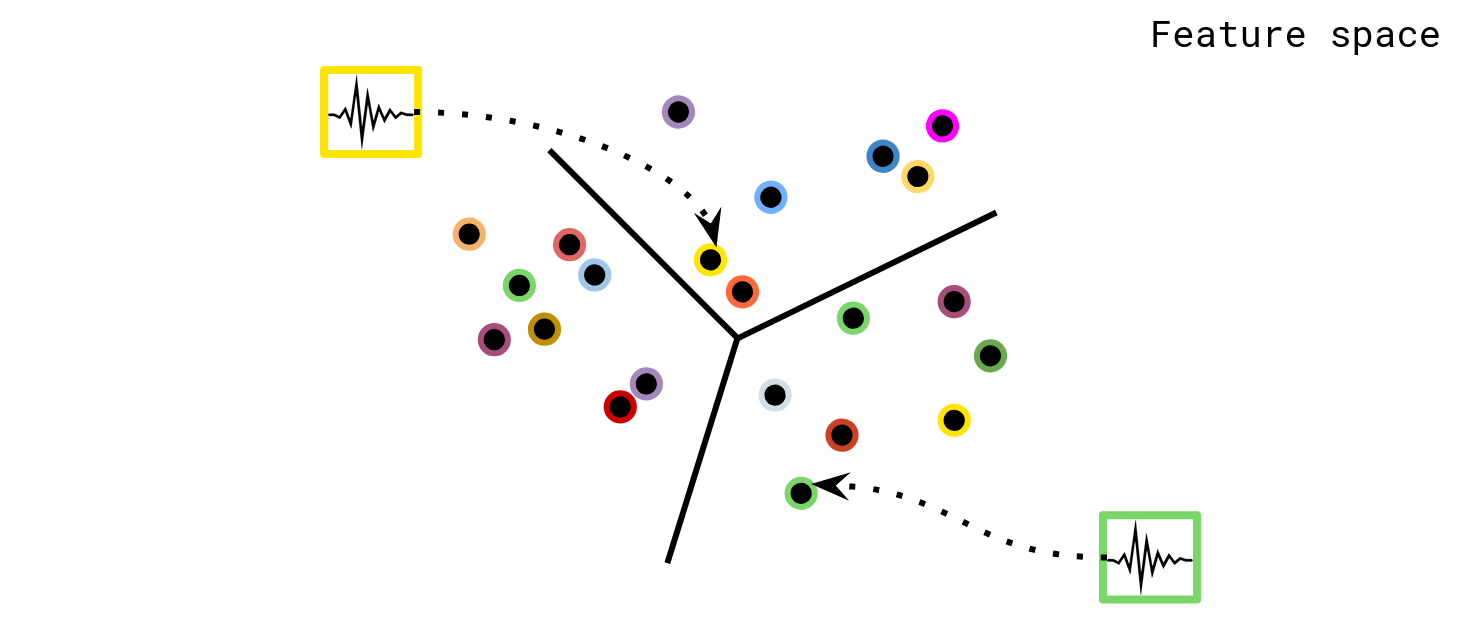

In [22]:
pd.read_csv("mtt_ssl/train/annotations.csv")

,mp3_path,guitar,classical,slow,techno,drums,strings,rock,electronic,fast,...,choir,no voice,dance,metal,voice,male voice,country,harp,male vocals,electro
0,0/american_bach_soloists-j_s__bach__cantatas_v...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,f/the_headroom_project-jetuton_andawai-01-lind...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9/american_bach_soloists-heinrich_schutz__musi...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9/american_bach_soloists-heinrich_schutz__musi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9/american_bach_soloists-heinrich_schutz__musi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,3/musica_franca-boismortier__sonatas_for_two_b...,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2590,3/musica_franca-boismortier__sonatas_for_two_b...,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2591,f/magnaloops-electronica_loops_1-43-osxivilion...,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2592,8/jacob_heringman-blame_not_my_lute-57-lost_is...,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


The quantity of annotated data is 10x smaller than the non-annotated one. We will now use this small quantity of data to train a simple linear probe in a supervised way, on top of the learned embeddings.

Let us first build our `MultiLabelDataset` class.

In [23]:
class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir: str, duration: float = None, sample_rate: int = 22050):
        """
        Args:
            data_dir (str): Root directory of the dataset, containing the annotations.csv and audio files.
            duration (float, optional): Duration of audio samples in seconds. If None, load full audio.
            sample_rate (int): The sample rate to use when loading audio.
        """
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.duration = duration

        # Define the path to the annotations file inside the data_dir
        annotations_file = os.path.join(data_dir, "annotations.csv")

        # Load annotations from CSV
        self.annotations = pd.read_csv(annotations_file)

        # Extract wav paths and labels from the CSV
        self.paths, self.labels = [], []
        for path, label in zip(self.annotations["mp3_path"].values, self.annotations.drop(columns=["mp3_path"]).values):
            if os.path.exists(os.path.join(self.data_dir, path)):
                self.paths.append(path)
                self.labels.append(label)

        self.num_frames = int(self.sample_rate * self.duration)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx: int):
        # Get the file path and the corresponding label
        audio_path = os.path.join(self.data_dir, self.paths[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        # Load audio file
        waveform, sr = torchaudio.load(audio_path, num_frames=self.num_frames)

        return waveform, label


### 2.2. Linear probe as a `LightningModule`

We then define our linear probe as a `LightningModule`. This probe takes as argument the backbone model that we previously trained, as well as its output dimension and the number of labels of our supervised task.

We use the same naming convention as earlier for the encoder, enabling us to load the pretrained encoder in the linear probe seamlessly.

Since we are in a multilabel scenario, the linear probe is followed by a sigmoid function that individually maps all outputs in $[0, 1]$. We then optimize the Binary Cross-Entropy between the predicted activation probabilities and our actual annotations.

We evaluate the performances of our model by measuring two metrics: **mean Average Precision** and **ROC-AUC**.

##### Mean Average Precision (mAP)

Mean Average Precision (mAP) is a performance metric used to evaluate the accuracy of a multilabel classification model. In this context, it measures how well the model ranks relevant labels higher than irrelevant ones across multiple classes. The mAP is the mean of the average precision scores for each label, calculated as follows:

1. **Precision and Recall:** For each label, calculate the precision and recall at each prediction threshold.
   - **Precision** is the ratio of true positive predictions to the total number of positive predictions.
   - **Recall** is the ratio of true positive predictions to the total number of actual positives.
   
2. **Average Precision (AP):** For each label, plot the precision-recall curve and calculate the area under this curve. This gives the AP for that label.

3. **Mean Average Precision (mAP):** Compute the mean of the AP values across all labels to obtain the mAP score.

The mAP provides a single score that summarizes the performance of the model across all labels, taking into account both the precision and recall.

##### ROC-AUC

The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are used to evaluate the performance of a classification model. In the context of multilabel classification, the ROC-AUC is calculated for each label independently and then averaged.

1. **ROC Curve:** For each label, plot the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
   - **True Positive Rate (TPR)** is the ratio of true positives to the total number of actual positives.
   - **False Positive Rate (FPR)** is the ratio of false positives to the total number of actual negatives.

2. **AUC (Area Under the Curve):** The AUC represents the probability that the model ranks a randomly chosen positive instance higher than a randomly chosen negative instance. An AUC of 1 indicates perfect performance, while an AUC of 0.5 indicates performance no better than random guessing.

3. **Mean ROC-AUC:** Calculate the AUC for each label and then take the average of these AUC scores to obtain the mean ROC-AUC. This provides a single metric that reflects the model's overall ability to discriminate between the positive and negative classes across all labels.

For simplicity, we do not focus here on the specific implementation of these metrics and use the existing one from `scikit-learn`.


In [24]:
class LinearProbe(pl.LightningModule):
    def __init__(self,
                 backbone: torch.nn.Module,
                 backbone_dim: int,
                 num_labels: int,
                 precomputed_embeddings: bool = False):
        super(LinearProbe, self).__init__()

        self.encoder = backbone
        self.probe = torch.nn.Linear(backbone_dim, num_labels)
        self.loss_fn = torch.nn.BCELoss()  # Use binary cross-entropy for multi-label classification
        self.precomputed_embeddings = precomputed_embeddings

        # During evaluation, freeze the backbone and discard the final projection layer
        for p in self.encoder.parameters():
            p.requires_grad = False

        # Store predictions and labels for the entire epoch
        self.all_preds = []
        self.all_labels = []

    def forward(self, x):
        if self.precomputed_embeddings:
            z = x
        else:
            with torch.no_grad():
                z = self.encoder(x)

        return torch.sigmoid(self.probe(z))

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)

        loss = self.loss_fn(preds, y)
        self.log(f"train_loss", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        preds = self.forward(x)
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss)

        # Store predictions and labels for metric calculation at the end of the epoch
        self.all_preds.append(preds.cpu())
        self.all_labels.append(y.cpu())

        return preds, y

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking:
            # Concatenate predictions and labels across all batches
            all_preds = torch.cat(self.all_preds, dim=0)
            all_labels = torch.cat(self.all_labels, dim=0)
    
            # Calculate mAP and ROC AUC
            self.calculate_metrics(all_preds, all_labels)

        # Clear the lists for the next epoch
        self.all_preds = []
        self.all_labels = []

    def calculate_metrics(self, preds, labels):
        # Convert to numpy arrays for metric calculation
        preds_np = preds.numpy()
        labels_np = labels.numpy()

        # Calculate mAP and ROC AUC
        mAP = average_precision_score(labels_np, preds_np, average='macro')  # mAP for multi-label
        roc_auc = roc_auc_score(labels_np, preds_np, average='macro')  # ROC AUC for multi-label

        # Log the metrics
        self.log("mAP", mAP, prog_bar=True)
        self.log("ROC-AUC", roc_auc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.probe.parameters(), lr=1e-3)
        return optimizer

In [25]:
probe = LinearProbe.load_from_checkpoint("logs/x-ent/last.ckpt",
                                         strict=False,
                                         backbone=SampleCNN(),
                                         backbone_dim=512,
                                         num_labels=50,
                                         precomputed_embeddings=True)

/home/alain/miniconda3/envs/ar/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:173: UserWarning:

Found keys that are in the model state dict but not in the checkpoint: ['probe.weight', 'probe.bias']

/home/alain/miniconda3/envs/ar/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:177: UserWarning:

Found keys that are not in the model state dict but in the checkpoint: ['projector.0.weight', 'projector.2.weight']



### Bonus: Precomputing the embeddings

You may have noticed an additional argument of the `LinearProbe` class: `precomputed_embeddings`. Indeed, a common strategy to speed up the evaluation of an SSL model is to first project the whole datasets in the latent space and store the embeddings in a big table. Since the linear probe is way lighter than the encoder, precomputing the embeddings significantly reduces the GPU requirements and speeds up the probe's training.

Here we implement a simple function that takes as input a trained neural network and a PyTorch `Dataset`, and returns a dataset of the precomputed embeddings with the corresponding labels. 

In [26]:
@torch.inference_mode()  # this decorator automatically disables gradients, making the process faster
def cache_embeddings(
    model: torch.nn.Module, 
    dataset: torch.utils.data.Dataset, 
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    batch_size: int = 32,
) -> torch.utils.data.TensorDataset:
    """
    Cache embeddings by passing the dataset through the model and storing the embeddings.

    Args:
        model (torch.nn.Module): The model to generate embeddings, typically a backbone.
        dataset (torch.utils.data.Dataset): The dataset containing inputs and labels.
        device (torch.device): The device to run the model on (default is "cuda").
        batch_size (int): Number of audios to encode in parallel.

    Returns:
        torch.utils.data.TensorDataset: A dataset containing normalized embeddings and their corresponding labels.
    """
    x_list, y_list = [], []  # Lists to hold embeddings and labels
    buffer = []
    model = model.to(device)  # Move model to the specified device

    for x, y in tqdm(dataset, desc="Caching embeddings", leave=False):
        y_list.append(y)  # Store label

        # Instead of computing the embedding of each audio sequentially, we keep a buffer of audios that we then process in parallel
        # This enables to take advantage of the GPU parallel computing, and speeds up the overall preprocessing
        buffer.append(x)
        if len(buffer) == batch_size:
            buffer = torch.cat(buffer)
            x = buffer.to(device)  # Move input to device
            x = model(x)  # Get embedding from the model
            x_list.append(x)  # Store embedding
            assert len(x_list) * batch_size == len(y_list), f"{len(x_list)} {len(y_list)}"
            buffer = []

    # add the last part of the batch
    if buffer != []:
        buffer = torch.cat(buffer)
        x = buffer.to(device)  # Move input to device
        x = model(x)  # Get embedding from the model

        x_list.append(x)  # Store embedding

    # Concatenate embeddings and convert labels to tensors
    x_tensor = torch.cat(x_list, dim=0).cpu()  # Move embeddings back to CPU
    y_tensor = torch.stack(y_list, dim=0).cpu()  # Convert labels to tensor

    # Normalize embeddings and return them along with labels
    return torch.utils.data.TensorDataset(torch.nn.functional.normalize(x_tensor, dim=-1), y_tensor)

In [27]:
# compute the embeddings
train_set = MultiLabelDataset("mtt_ssl/train", duration=25.)
val_set = MultiLabelDataset("mtt_ssl/test", duration=25.)
columns = train_set.annotations.columns[1:]

print(f"Training set: {len(train_set)} files")
print(f"Validation set: {len(val_set)} files")

Training set: 2069 files
Validation set: 525 files


In [28]:
try:
    train_set = cache_embeddings(probe.encoder, train_set)
    val_set = cache_embeddings(probe.encoder, val_set)
finally:
    torch.cuda.empty_cache()

Caching embeddings:   0%|          | 0/2069 [00:00<?, ?it/s]

Caching embeddings:   0%|          | 0/525 [00:00<?, ?it/s]

### 2.4. Visualization of the latent space

Before evaluating our SSL model quantitatively, we can first observe a 2D projection of our latent space and check whether audios that share similar tags are close from each other in this learned space. To do so, we can use a projection called Uniform Manifold Approximation and Projection (UMAP). Compared to PCA, this projection better preserves clusters.

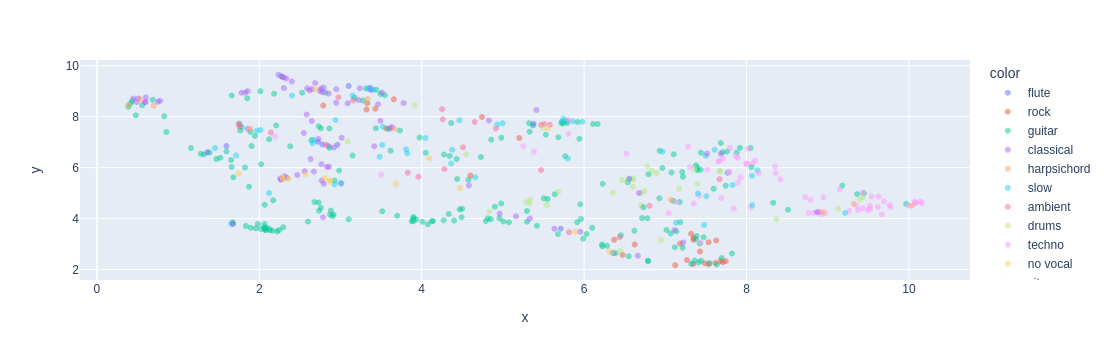

In [29]:
import plotly.express as px
import numpy as np
from umap import UMAP

# Assuming 'embeddings' and 'labels' are tensors in (n_samples, n_features) and (n_samples, n_labels)
embeddings, labels = val_set.tensors

# Use UMAP for dimensionality reduction
umap = UMAP(n_components=2)
proj = umap.fit_transform(embeddings.cpu().numpy())

# Convert labels to numpy array
labels = labels.cpu().numpy()

# Define color based on the first active label per row
color_labels = [columns[i] for i in np.argmax(labels, axis=1)]

# Generate hover text with the list of active labels for each point
hover_text = []
for row in labels:
    active_labels = [columns[i] for i, val in enumerate(row) if val == 1]
    hover_text.append(", ".join(active_labels))

# Plot with Plotly Express
fig = px.scatter(x=proj[:, 0], y=proj[:, 1], color=color_labels, hover_name=hover_text, opacity=0.5)
fig.show()

### 2.5. Downstream evaluation

Finally, let's train our **linear probe**.

In [30]:
train_dataloader = torch.utils.data.DataLoader(train_set,
                                               batch_size=256,
                                               num_workers=os.cpu_count(),
                                               shuffle=True,
                                               pin_memory=True,
                                               persistent_workers=True)

val_dataloader = torch.utils.data.DataLoader(val_set,
                                             batch_size=256,
                                             num_workers=os.cpu_count(),
                                             shuffle=False,
                                             pin_memory=False,
                                             persistent_workers=True)

# callbacks
early_stopping = pl.callbacks.EarlyStopping(monitor="mAP", mode="max", patience=20)

trainer = pl.Trainer(accelerator='gpu', max_epochs=500, callbacks=[early_stopping])

try:
    trainer.fit(probe, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
finally:
    torch.cuda.empty_cache()

Trainer will use only 1 of 7 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=7)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]

  | Name    | Type      | Params
--------------------------------------
0 | encoder | SampleCNN | 2.4 M 
1 | probe   | Linear    | 25.7 K
2 | loss_fn | BCELoss   | 0     
--------------------------------------
25.7 K    Trainable params
2.4 M     Non-trainable params
2.4 M     Total params
9.577     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/alain/miniconda3/envs/ar/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: PossibleUserWarning:

The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

That's it! Once your big SSL model is trained, such a simple linear classifier and a few annotated samples are all you need!

## 3. Conclusion

In this notebook, we saw how to both train and evaluate an SSL model based on Siamese networks. We focused in particular on contrastive learning, which is the most widely used technique, but of course there are many others.

Overall, the main directions of research are:
- *How to create positive pairs?* We can use transforms as in this notebook, however one can instead use masking, or even multimodal data (e.g. an audio and its description) to build multimodal latent spaces (see [CLIP](https://arxiv.org/abs/2103.00020), [CLAP](https://arxiv.org/abs/2206.04769), etc.)
- *How to prevent collapse?* In this notebook, we covered the contrastive loss but there are several other techniques, such as directly optimizing the batch statistics ([Wang et al.](https://arxiv.org/abs/2005.10242), [VICReg](https://arxiv.org/abs/2105.04906)...) or breaking the symmetry between the two branches of the Siamese network ([BYOL](https://arxiv.org/abs/2006.07733), etc.)

For going more into details, we strongly encourage the reader to check this great [Cookbook of Self-Supervised Learning](https://arxiv.org/abs/2304.12210).